In [ ]:
import torch
from torch import nn
from utils import device_check

print(torch.__version__)
device = device_check()

In [3]:
import os
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


In [4]:
walk_through_dir('./data/pizza_steak_sushi')

There are 2 directories and 0 images in './data/pizza_steak_sushi'.
There are 3 directories and 0 images in './data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in './data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in './data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in './data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in './data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in './data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in './data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in './data/pizza_steak_sushi/train/pizza'.


In [5]:
from pathlib import Path

data_dir = Path('./data/pizza_steak_sushi')

train_dir = data_dir / 'train'
test_dir = data_dir / 'test'


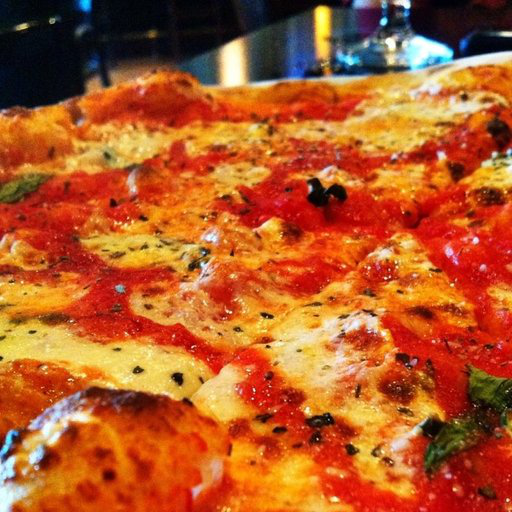

In [14]:
# visualization

import random
from PIL import Image

random.seed(42)

img_path_list = list(data_dir.glob('*/*/*.jpg'))
random_img_path = random.choice(img_path_list)
img_class = random_img_path.parent.name
img = Image.open(random_img_path)

img

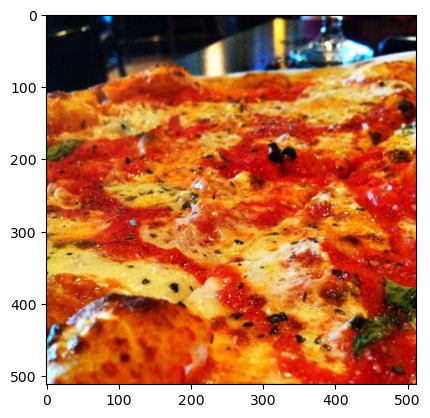

In [15]:
import numpy as np
import matplotlib.pyplot as plt

np_img = np.asarray(img)
plt.imshow(np_img)


In [16]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

trans = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor()
        ])



In [17]:
from torchvision import datasets

train_data = datasets.ImageFolder(root = train_dir, transform = trans, target_transform = None)
# target_transform: perform transformation on target

test_data = datasets.ImageFolder(root = test_dir, transform = trans)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [18]:
train_data.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

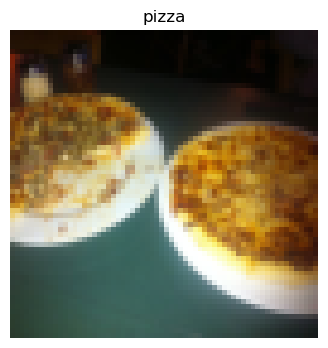

In [27]:
img = train_data[0][0]

plt.figure(figsize=(4, 4))
plt.imshow(img.permute(1, 2, 0))
plt.title(train_data.classes[train_data[0][1]])
plt.axis(False)
plt.show()


In [30]:
import os

train_dataloader = DataLoader(train_data, batch_size = 32, shuffle = True, num_workers = os.cpu_count())
test_dataloader = DataLoader(test_data, batch_size = 32, shuffle = True, num_workers = os.cpu_count())

imgs, labels = next(iter(train_dataloader))
imgs.shape, labels.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [31]:
# Custom Dataset

import os
import torch
import pathlib

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List


In [32]:
def find_classes(dir: str) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted(entry.name for entry in os.scandir(dir) if entry.is_dir())
    if not classes:
        raise FileExistsError(f"Cannot find any subclasses")

    class_to_idx = {name:idx for idx, name in enumerate(classes)}

    return classes, class_to_idx

In [33]:
class CustomData(Dataset):
    def __init__(self, dir: str, transform = None) -> None:
        self.all_path = list(pathlib.Path(dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(dir)

    def load_img(self, index: int) -> Image.Image:
        img_path = self.all_path[index]
        return Image.open(img_path)

    def __len__(self):
        return len(self.all_path)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_img(index)
        class_name = self.all_path[index].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [34]:
train_trans = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(p = .5),
        transforms.ToTensor()
        ])

test_trans = transforms.Compose([
        transforms.Resize([64, 64]),
        transforms.ToTensor()
        ])

In [37]:
custom_train_data = CustomData(train_dir, train_trans)
custom_test_data = CustomData(test_dir, test_trans)

print(len(custom_train_data), len(custom_test_data))
print(custom_train_data.classes)
print(custom_test_data.class_to_idx)

225 75
['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}


In [44]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None) -> None:
    if n > 10:
        n = 10
        display_shape = False

    if seed:
        random.seed(seed)

    random_idx = random.sample(range(len(dataset)), k = n)

    plt.figure()

    for i, idx in enumerate(random_idx):
        img, label = dataset[idx]

        plt.subplot(1, n, i + 1)
        plt.imshow(img.permute(1, 2, 0))
        plt.axis("off")

        if classes:
            title = f"class: {classes[label]}"
            if display_shape:
                title += f"\nshape: {img.shape}"
        plt.title(title)

    plt.show()
    return

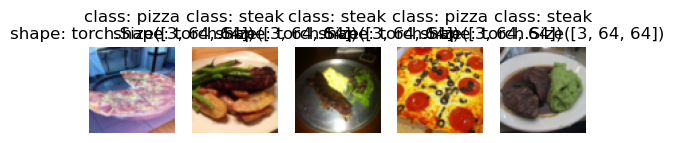

In [45]:
display_random_images(custom_train_data, custom_train_data.classes, 5, display_shape = True, seed
= 42)

In [ ]:
custom_train_loader = DataLoader(dataset = custom_train_data, batch_size = 64, num_workers = os
                                 .cpu_count() / 2,  shuffle = True)
custom_test_loader = DataLoader(dataset = custom_test_data, batch_size = 128, num_workers = os
                                .cpu_count() / 2, shuffle = False)


In [46]:
train_trans = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.TrivialAugmentWide(num_magnitude_bins = 31),
        transforms.ToTensor()
        ])

test_trans = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
        ])



In [48]:
list(data_dir.glob("*/*/*.jpg")).__len__()

300

In [ ]:
import torchvision
def pred_and_plot(model: torch.nn.Module,
                  img_path: str,
                  class_names: List[str] = None,
                  transform = None,
                  device: torch.device = device):

    img = torchvision.io.read_image(str(img_path)).to(torch.float32)
    img = img / 255.0

    if transform:
        img = transform(img)

    model.to(device)

    model.eval()
    with torch.inference_mode():
        img = img.unsqueeze(dim = 0)
        y_hat = model(img.to(device))

    y_probabilities = torch.softmax(y_hat, dim = 1)
    y_label = torch.argmax(y_probabilities, dim = 1)

    plt.figure()
    plt.imshow(img.squeeze().permute(1, 2, 0))

    if class_names:
        title = f"Pred: {class_names[y_label.cpu()]} | Prob: {y_probabilities.max().cpu(): .3f}"
    else:
        title = f"Pred: {y_label.item()} | Prob: {y_probabilities.max().cpu(): .3f}"

    plt.title()
    plt.axis(False)
    plt.show()